In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import fastcluster
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from ete3 import NCBITaxa
ncbi = NCBITaxa()

# Load the OG DataFrame

In [2]:
RootOGs = pd.read_pickle("../Data/output/OGTrimmed.pkl")
Jaccard_dist = pd.read_pickle("../Data/output/OGJaccardDist.pkl")

# Create hierarchichal clusters

In [3]:
%%time
linkage = hc.linkage(sp.distance.squareform(Jaccard_dist), method='average')

CPU times: user 7.81 s, sys: 2.54 s, total: 10.3 s
Wall time: 10.8 s


#from scipy.cluster.hierarchy import fcluster
clust = hc.fcluster(linkage, 500, criterion='maxclust')
pd.Series(clust).value_counts()

In [4]:
T_range = np.arange(0,1.01, 0.01)

clusters = pd.DataFrame(index = Jaccard_dist.index, columns = T_range)
#clusters = pd.DataFrame(index = Jaccard_sim1.index, columns = ["Function",T_range])
#clusters["Function"] = OGFunction.Function
clusters

for T in T_range:
    clusters[T] = hc.fcluster(linkage, t=T, criterion='distance')
    #clusters[k] = scipy.cluster.hierarchy.fcluster(linkage, k, criterion='maxclust')

clusters

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
COG,,,,,,,,,,,,,,,,,,,,,
28H52,11386,11252,11133,11051,10976,10911,10865,10798,10745,10700,...,2084,1777,1459,1167,897,647,436,252,83,1
28H58,5569,5565,5561,5548,5529,5516,5503,5486,5474,5457,...,1622,1393,1158,944,740,550,381,226,82,1
28H5D,12494,12360,12241,12159,12084,12019,11973,11904,11851,11805,...,2361,2002,1644,1312,1002,729,485,275,86,1
28H5M,1389,1389,1389,1388,1388,1387,1387,1384,1382,1380,...,508,447,377,319,250,200,139,91,36,1
28H5N,11456,11322,11203,11121,11046,10981,10935,10868,10815,10770,...,2110,1800,1480,1184,910,656,442,255,83,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
arCOG14808,3326,3326,3326,3323,3323,3320,3319,3313,3309,3306,...,1178,1016,844,704,549,408,286,173,68,1
arCOG14814,5842,5838,5834,5821,5801,5788,5775,5758,5746,5729,...,1726,1484,1240,1008,791,587,402,235,83,1
arCOG14922,11284,11150,11031,10949,10874,10809,10763,10696,10643,10598,...,2082,1775,1459,1167,897,647,436,252,83,1


All OGs


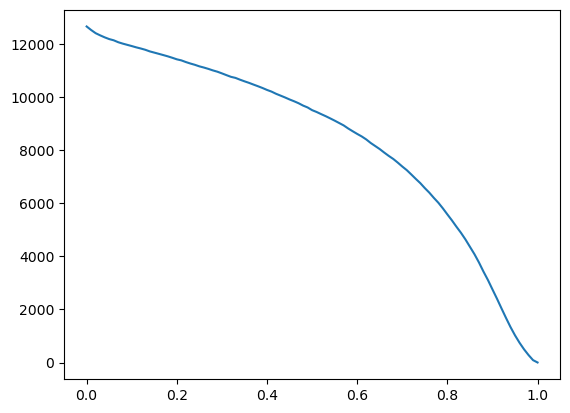

In [5]:
plt.plot(T_range,clusters.nunique())
print("All OGs")
plt.show()

In [24]:
clustering = pd.DataFrame(hc.fcluster(linkage, t=0.85, criterion='distance'), index = Jaccard_dist.index)
#clustering["Function"] = OGFunction.Function
Counts = clustering.value_counts()
Counts = Counts[Counts > 1]
Counts

3569    2653
2499     394
3584     270
3523     204
3698     147
        ... 
4307       2
3719       2
863        2
4305       2
233        2
Length: 1183, dtype: int64

In [26]:
WLP_genes = pd.Series(["COG1614","COG1152","COG1456","COG2069","COG1410","COG1880"])

clusternr = clustering.loc[WLP_genes,0].value_counts()#.idxmax()
clusternr,Counts.loc[clusternr.index]

(2465    4
 3569    1
 2458    1
 Name: 0, dtype: int64,
 2465      16
 3569    2653
 2458      99
 dtype: int64)

CPU times: user 579 ms, sys: 583 ms, total: 1.16 s
Wall time: 828 ms


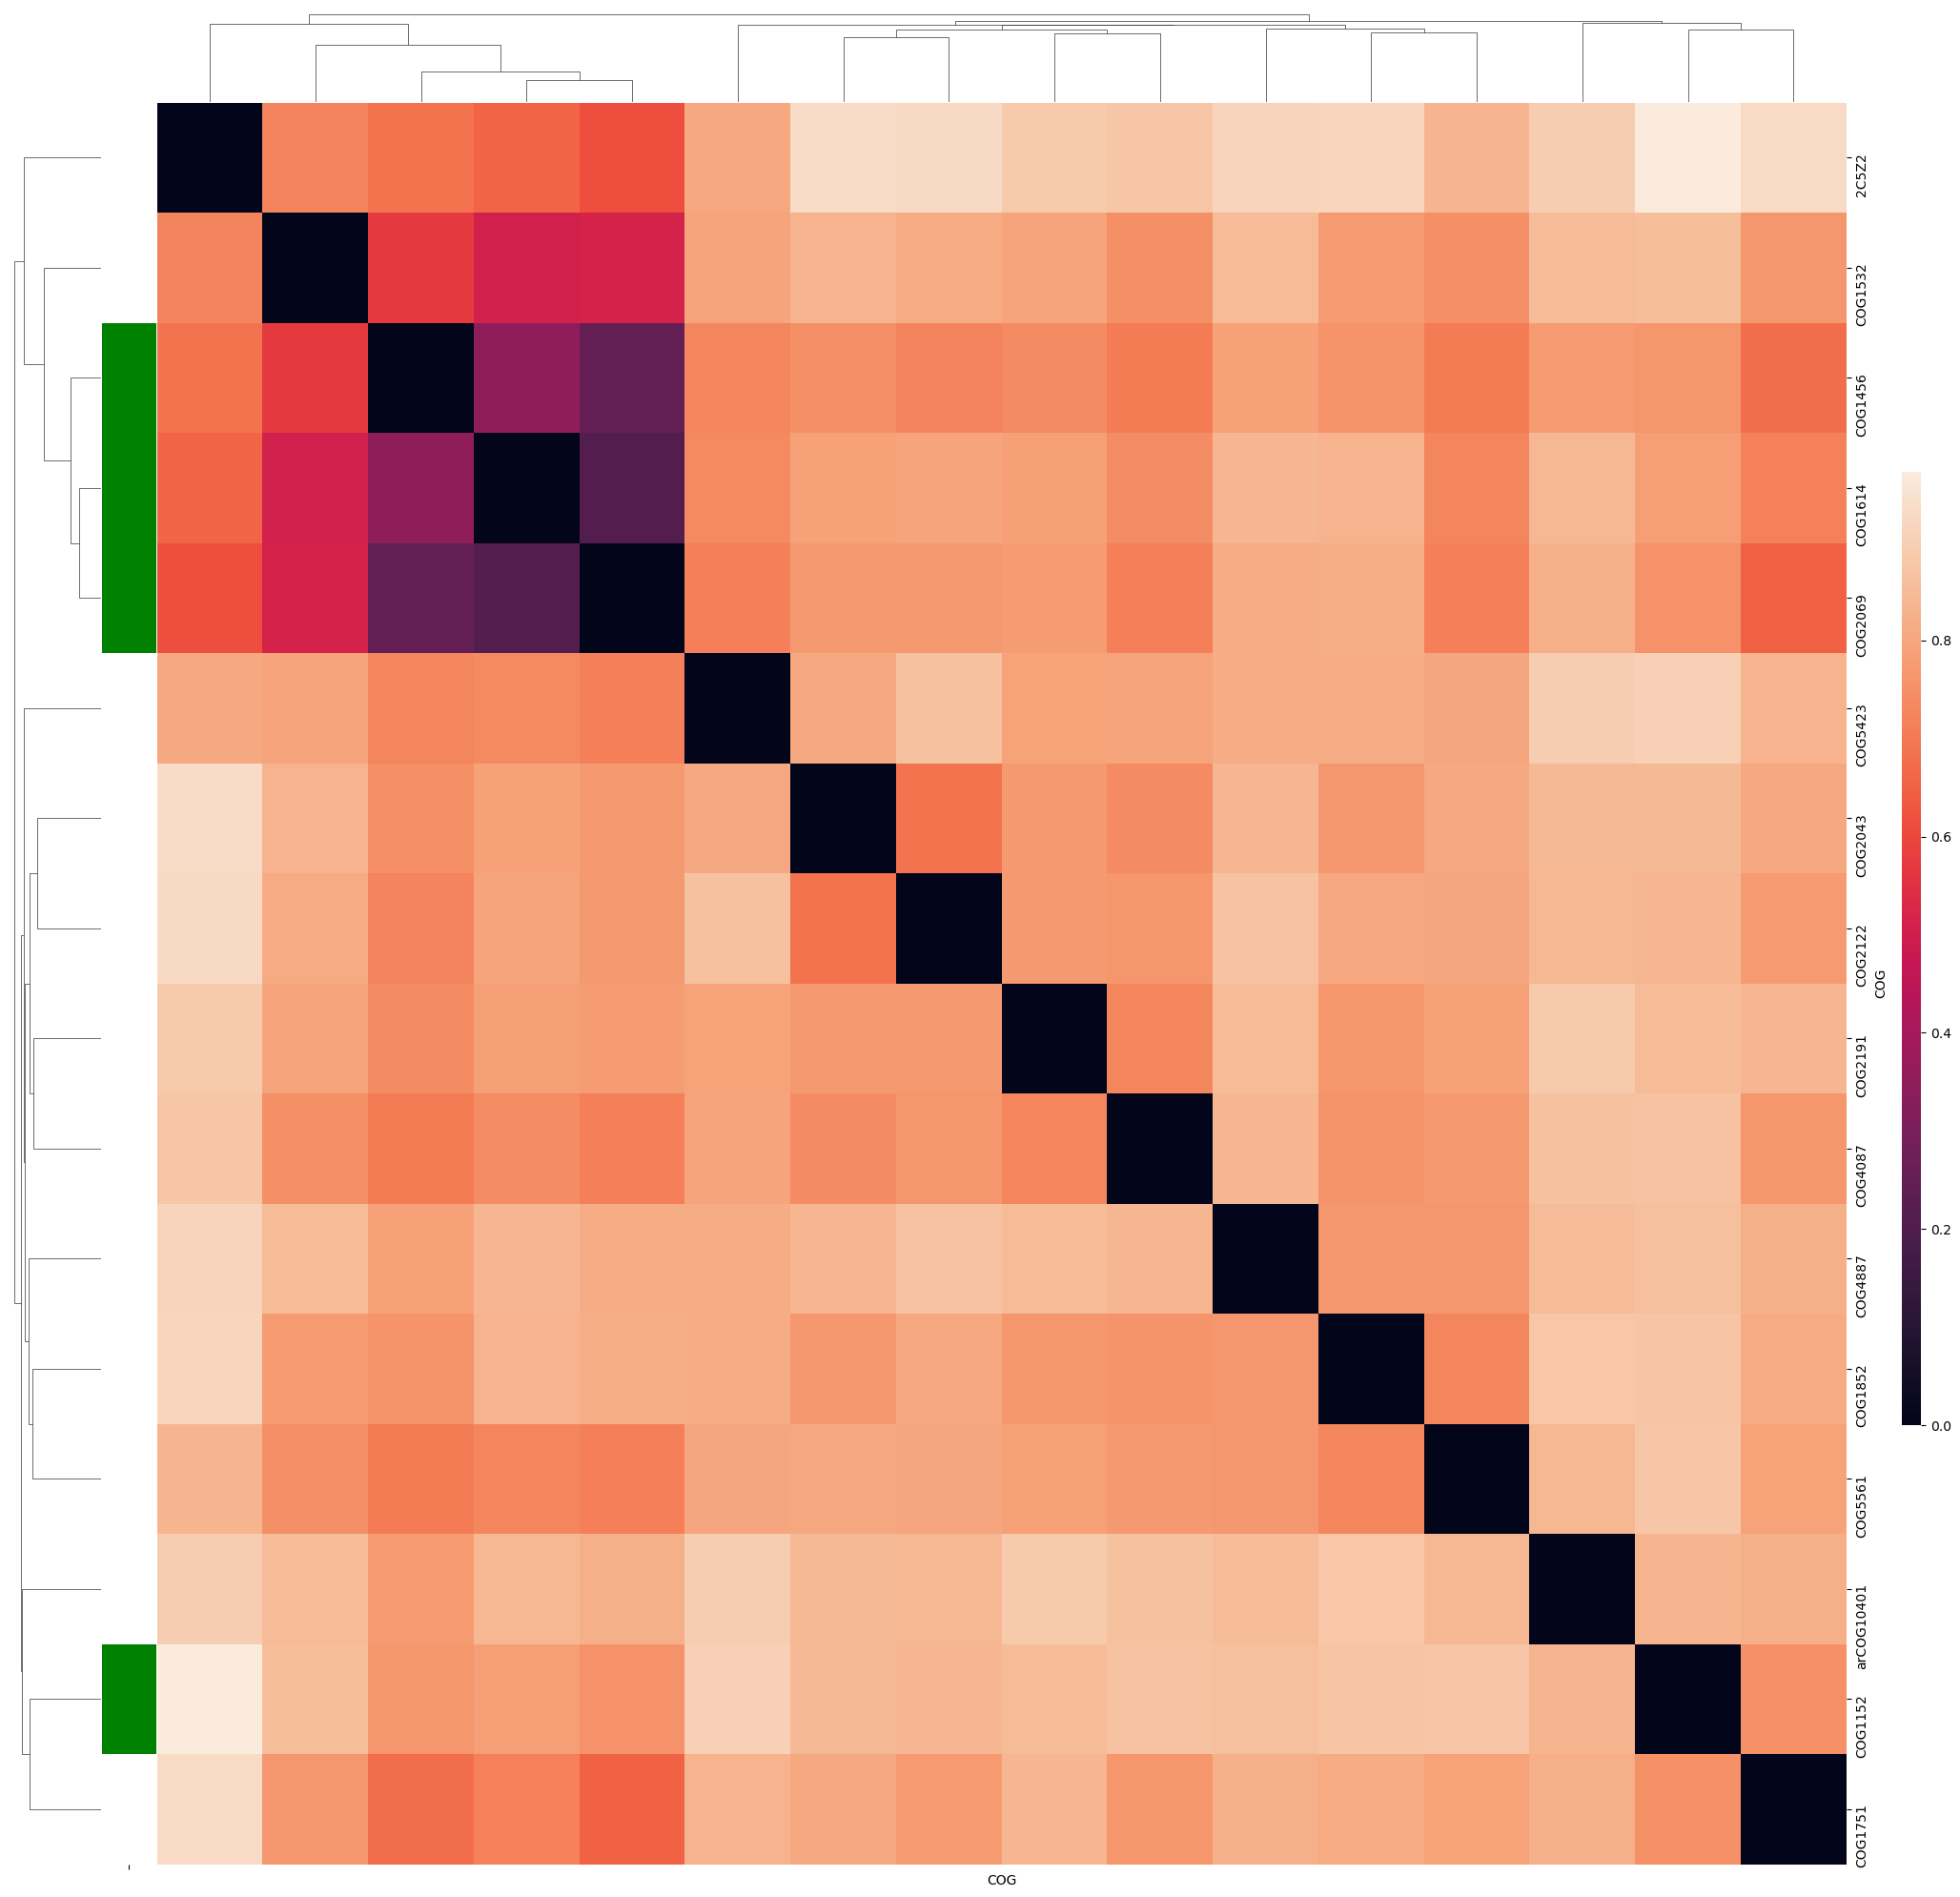

In [27]:
%%time
function = pd.Series("CoreWLP", index = WLP_genes)
lut = dict(zip(function.unique(), "g"))
row_colors = function.map(lut)

mask = clustering[clustering.iloc[:,0] == clusternr.index[0]].index
SubJaccard = Jaccard_dist.loc[mask,mask]

OGHeatMap = sns.clustermap(SubJaccard, figsize=(20, 20), dendrogram_ratio=0.05, row_colors=row_colors, cbar_pos=(1, 0.25, 0.01, 0.5), row_cluster=True, yticklabels=True, xticklabels=False)

In [28]:
ordered = pd.Series(OGHeatMap.ax_heatmap.yaxis.get_majorticklabels()).astype(str).str.split("'", expand = True)[1]

Order = pd.read_pickle("../Data/output/OGTrimmedTax.pkl")
Annotations = pd.read_csv("../Data/input/1_annotations.tsv", delimiter="\t", header = None).set_index(1) #download from eggNOG if needed

Cluster = Annotations.loc[ordered]
Cluster["SpCount"] = Order.sum(axis = 1).astype(int)
Cluster = Cluster.drop(axis=1, labels= 0)

Cluster = Cluster.join(Order.loc[ordered, Order.loc[ordered].sum(axis = 0) != 0])

with pd.option_context('display.max_rows', None,):
        print(Cluster)

            2                                                  3  SpCount  \
1                                                                           
2C5Z2       S               Domain of unknown function (DUF3786)       57   
COG1532     S                      Predicted RNA-binding protein      122   
COG1456     C                       acetyl-CoA catabolic process      182   
COG1614     C        CO-methylating acetyl-CoA synthase activity      166   
COG2069     C                       one-carbon metabolic process      147   
COG5423     S          Predicted metal-binding protein (DUF2284)      209   
COG2043     S                      Uncharacterised ArCR, COG2043      363   
COG2122     S                                                NaN      320   
COG2191     C  FmdE, Molybdenum formylmethanofuran dehydrogen...      387   
COG4087     S     Haloacid dehalogenase domain protein hydrolase      203   
COG4887     S              Protein of unknown function (DUF1847)      217   